# Microsoft Malware detection

In this kernel, I build a LGBM model using only a subset of the training data, in order to fit in memory.

## Notebook  Content
1. [Utility functions](#0)
1. [Loading the data](#1) <br>
    2.1 [Get the files and select the variables](#2.1) <br>
    2.2 [Define the type of each variable](#2.2)
1. [Feature engineering](#2) <br>
    3.1 [Frequency encoding](#3.1) <br>
    3.2 [Label encoding](#3.2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
#Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

from IPython.core.display import display, HTML, display_html
display(HTML("<style>.container { width:99% !important; }</style>")) # set full window wide cells (only in this notebook)

In [1]:
import pandas as pd
import numpy as np
import re
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML, display_html
display(HTML("<style>.container { width:99% !important; }</style>")) # set full window wide cells (only in this notebook)

# Display some dataframes in one cell from left to right 
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [7]:
%%bash
ls input/

test.csv
train.csv


In [6]:
%%bash
top -b -n 1 -p 1

top - 22:52:05 up 13 min,  1 user,  load average: 0,02, 0,01, 0,00
Tasks:   1 total,   0 running,   1 sleeping,   0 stopped,   0 zombie
%Cpu(s):  0,1 us,  0,1 sy,  0,0 ni, 99,6 id,  0,2 wa,  0,0 hi,  0,0 si,  0,0 st
KiB Mem : 32934580 total, 32475156 free,   251764 used,   207660 buff/cache
KiB Swap: 33535996 total, 33535996 free,        0 used. 32309552 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND
    1 root      20   0   57124   6900   5352 S   0,0  0,0   0:00.59 systemd


In [2]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [ ]:
#--------------------------------------------------------
def load(x):
    if x in ['MachineIdentifier']: return False
    else: return True
    
#--------------------------------------------------------
print('Start load df_train:', time.ctime()[11:-5])
df_train = pd.read_csv('input/train.csv', dtype='category', usecols=load, encoding='utf-8')#, nrows=1000000)
df_train['HasDetections'] = df_train['HasDetections'].astype('int8')

print('Start load df_test:', time.ctime()[11:-5])
df_test = pd.read_csv('input/test.csv', dtype='category', usecols=load, encoding='utf-8')#, usecols=load, nrows=1000000)

print('Finish loading:', time.ctime()[11:-5])

In [62]:
for col in df_train[:-1]:

    df1 = pd.DataFrame(df_train[df_train['HasDetections']==1][col].value_counts()).reset_index()
    #df1['index'] = pd.to_numeric(df1['index'])
    df1 = df1.sort_values('index').reset_index(drop=True)

    df0 = pd.DataFrame(df_train[df_train['HasDetections']==0][col].value_counts()).reset_index()
    #df0['index'] = pd.to_numeric(df0['index'])
    df0 = df0.sort_values('index').reset_index(drop=True)

    print(time.ctime()[11:-5], col, len(df1), len(df0))


00:29:41 ProductName 6 6
00:29:43 EngineVersion 70 70
00:29:45 AppVersion 110 110
00:29:47 AvSigVersion 8531 8531
00:29:50 IsBeta 2 2
00:29:52 RtpStateBitfield 7 7
00:29:54 IsSxsPassiveMode 2 2
00:29:56 DefaultBrowsersIdentifier 2017 2017
00:29:58 AVProductStatesIdentifier 28970 28970
00:30:00 AVProductsInstalled 8 8
00:30:02 AVProductsEnabled 6 6
00:30:05 HasTpm 2 2
00:30:07 CountryIdentifier 222 222
00:30:09 CityIdentifier 107366 107366
00:30:11 OrganizationIdentifier 49 49
00:30:13 GeoNameIdentifier 292 292
00:30:16 LocaleEnglishNameIdentifier 276 276
00:30:18 Platform 4 4
00:30:20 Processor 3 3
00:30:22 OsVer 58 58
00:30:24 OsBuild 76 76
00:30:26 OsSuite 14 14
00:30:28 OsPlatformSubRelease 9 9
00:30:30 OsBuildLab 663 663
00:30:33 SkuEdition 8 8
00:30:35 IsProtected 2 2
00:30:37 AutoSampleOptIn 2 2
00:30:39 PuaMode 2 2
00:30:41 SMode 2 2
00:30:43 IeVerIdentifier 303 303
00:30:45 SmartScreen 21 21
00:30:47 Firewall 2 2
00:30:50 UacLuaenable 11 11
00:30:52 Census_MDC2FormFactor 13 13


for col in df_train[:-1]:
    print(col, end=' ')

In [67]:
#--------------------------------------------------------
print(' Start ranging:', time.ctime()[11:-5])
#Country weight

print(df_train.memory_usage(deep=True).sum())

for col in df_train[:-1]:

    df1 = pd.DataFrame(df_train[df_train['HasDetections']==1][col].value_counts()).reset_index()
    #df1['index'] = pd.to_numeric(df1['index'])
    df1 = df1.sort_values('index').reset_index(drop=True)

    df0 = pd.DataFrame(df_train[df_train['HasDetections']==0][col].value_counts()).reset_index()
    #df0['index'] = pd.to_numeric(df0['index'])
    df0 = df0.sort_values('index').reset_index(drop=True)

    print(time.ctime()[11:-5], col, len(df1), len(df0))
    df = df1.merge(df0, how='left', on='index')
    df['div'] =  df[col+'_x'] / (df[col+'_x'] + df[col+'_y'])

    if len(df1)<400:
        df_train[col+'_'] = 0.5
        for idx, div in zip(df['index'], df['div']):
            #print(idx, end=' ')
            df_train2[col+'_'][df_train[col]==idx] = div
        df_train[col+'_'] = pd.to_numeric(df_train[col+'_']).astype(np.float16)
    else:
        print('Pass')
        df_train[col+'_'] = df_train[col]
    
print('Finish ranging:', time.ctime()[11:-5])
print(df_train.memory_usage(deep=True).sum())
#df.sort_values('div', ascending=False)
df_train['HasDetections'] = pd.read_csv('input/train.csv', dtype='object', usecols=[-1])

 Start ranging: 00:40:16
1143086759
00:40:19 ProductName 6 6
00:40:21 EngineVersion 70 70
00:40:30 AppVersion 110 110
00:40:43 AvSigVersion 8531 8531
Pass
00:40:45 IsBeta 2 2
00:40:48 RtpStateBitfield 7 7
00:40:51 IsSxsPassiveMode 2 2
00:40:53 DefaultBrowsersIdentifier 2017 2017
Pass
00:40:56 AVProductStatesIdentifier 28970 28970
Pass
00:40:58 AVProductsInstalled 8 8
00:41:01 AVProductsEnabled 6 6
00:41:04 HasTpm 2 2
00:41:07 CountryIdentifier 222 222
00:41:31 CityIdentifier 107366 107366
Pass
00:41:34 OrganizationIdentifier 49 49
00:41:42 GeoNameIdentifier 292 292
00:42:13 LocaleEnglishNameIdentifier 276 276
00:42:42 Platform 4 4
00:42:45 Processor 3 3
00:42:48 OsVer 58 58
00:42:56 OsBuild 76 76
00:43:06 OsSuite 14 14
00:43:10 OsPlatformSubRelease 9 9
00:43:14 OsBuildLab 663 663
Pass
00:43:16 SkuEdition 8 8
00:43:20 IsProtected 2 2
00:43:23 AutoSampleOptIn 2 2
00:43:26 PuaMode 2 2
00:43:29 SMode 2 2
00:43:32 IeVerIdentifier 303 303
00:44:05 SmartScreen 21 21
00:44:10 Firewall 2 2
00:4

KeyError: 'HasDetections_'

In [54]:
df_train = df_train.iloc[:,:82]
df_train.head()
#df_train = df_train.drop(columns=['ProductName2','ProductName2_','HasDetections_'])

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7,0,NaN,53447,1,1,1,29,128035,18,35,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1,0,NaN,0,137,NaN,1,1,Desktop,Windows.Desktop,2668,9124,4,5,2341,NaN,476940,HDD,299451,0,4096,Desktop,18.9,1440,900,Desktop,NaN,4294967295,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0,Retail,NaN,628,36144,0,NaN,0,0,0,0,0,10,0
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7,0,NaN,53447,1,1,1,93,1482,18,119,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1,0,NaN,0,137,NaN,1,1,Notebook,Windows.Desktop,2668,91656,4,5,2405,NaN,476940,HDD,102385,0,4096,Notebook,13.9,1366,768,Mobile,NaN,1,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8,31,UNKNOWN,0,OFFLINE,Retail,NaN,0,NOT_SET,NaN,628,57858,0,NaN,0,0,0,0,0,8,0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7,0,NaN,53447,1,1,1,86,153579,18,64,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1,0,NaN,0,137,RequireAdmin,1,1,Desktop,Windows.Desktop,4909,317701,4,5,1972,NaN,114473,SSD,113907,0,4096,Desktop,21.5,1920,1080,Desktop,NaN,4294967295,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0,Retail,NaN,142,52682,0,NaN,0,0,0,0,0,3,0
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7,0,NaN,53447,1,1,1,88,20710,NaN,117,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1,0,NaN,0,137,ExistsNotSet,1,1,Desktop,Windows.Desktop,1443,275890,4,5,2273,NaN,238475,UNKNOWN,227116,0,4096,MiniTower,18.5,1366,768,Desktop,NaN,4294967295,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0,Retail,NaN,355,20050,0,NaN,0,0,0,0,0,3,1
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7,0,NaN,53447,1,1,1,18,37376,NaN,277,75,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1,0,NaN,0,137,RequireAdmin,1,1,Notebook,Windows.Desktop,1443,331929,4,5,2500,NaN,476940,HDD,101900,0,6144,

In [72]:
df_train2 = df_train.iloc[:,81:-1]
print(df_train2.memory_usage(deep=True).sum())
df_train2.to_csv('df_train2.csv', index=False, sep=',')
df_train2.head()

1642433412


,HasDetections,ProductName_,EngineVersion_,AppVersion_,AvSigVersion_,IsBeta_,RtpStateBitfield_,IsSxsPassiveMode_,DefaultBrowsersIdentifier_,AVProductStatesIdentifier_,AVProductsInstalled_,AVProductsEnabled_,HasTpm_,CountryIdentifier_,CityIdentifier_,OrganizationIdentifier_,GeoNameIdentifier_,LocaleEnglishNameIdentifier_,Platform_,Processor_,OsVer_,OsBuild_,OsSuite_,OsPlatformSubRelease_,OsBuildLab_,SkuEdition_,IsProtected_,AutoSampleOptIn_,PuaMode_,SMode_,IeVerIdentifier_,SmartScreen_,Firewall_,UacLuaenable_,Census_MDC2FormFactor_,Census_DeviceFamily_,Census_OEMNameIdentifier_,Census_OEMModelIdentifier_,Census_ProcessorCoreCount_,Census_ProcessorManufacturerIdentifier_,Census_ProcessorModelIdentifier_,Census_ProcessorClass_,Census_PrimaryDiskTotalCapacity_,Census_PrimaryDiskTypeName_,Census_SystemVolumeTotalCapacity_,Census_HasOpticalDiskDrive_,Census_TotalPhysicalRAM_,Census_ChassisTypeName_,Census_InternalPrimaryDiagonalDisplaySizeInInches_,Census_InternalPrimaryDisplayResolutionHorizontal_,Census_InternalPrimaryDisplayResolutionVertical_,Census_PowerPlatformRoleName_,Census_InternalBatteryType_,Census_InternalBatteryNumberOfCharges_,Census_OSVersion_,Census_OSArchitecture_,Census_OSBranch_,Census_OSBuildNumber_,Census_OSBuildRevision_,Census_OSEdition_,Census_OSSkuName_,Census_OSInstallTypeName_,Census_OSInstallLanguageIdentifier_,Census_OSUILocaleIdentifier_,Census_OSWUAutoUpdateOptionsName_,Census_IsPortableOperatingSystem_,Census_GenuineStateName_,Census_ActivationChannel_,Census_IsFlightingInternal_,Census_IsFlightsDisabled_,Census_FlightRing_,Census_ThresholdOptIn_,Census_FirmwareManufacturerIdentifier_,Census_FirmwareVersionIdentifier_,Census_IsSecureBootEnabled_,Census_IsWIMBootEnabled_,Census_IsVirtualDevice_,Census_IsTouchEnabled_,Census_IsPenCapable_,Census_IsAlwaysOnAlwaysConnectedCapable_,Wdft_IsGamer_,Wdft_RegionIdentifier_
0,0,0.5,0.5,0.5,1.273.1735.0,0.5,0.5,0.5,NaN,53447,0.5,0.5,0.5,0.5,128035,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,17134.1.amd64fre.rs4_release.180410-1804,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2668,9124,0.5,0.5,2341,0.5,476940,0.5,299451,0.5,4096,0.5,18.9,1440,900,0.5,0.5,4294967295,10.0.17134.165,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,628,36144,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,0,0.5,0.5,0.5,1.263.48.0,0.5,0.5,0.5,NaN,53447,0.5,0.5,0.5,0.5,1482,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,17134.1.amd64fre.rs4_release.180410-1804,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,2668,91656,0.5,0.5,2405,0.5,476940,0.5,102385,0.5,4096,0.5,13.9,1366,768,0.5,0.5,1,10.0.17134.1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,628,57858,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0,0.5,0.5,0.5,1.273.1341.0,0.5,0.5,0.5,NaN,53447,0.5,0.5,0.5,0.5,153579,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,17134.1.amd64fre.rs4_release.180410-1804,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,4909,317701,0.5,0.5,1972,0.5,114473,0.5,113907,0.5,4096,0.5,21.5,1920,1080,0.5,0.5,4294967295,10.0.17134.165,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,142,52682,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,1,0.5,0.5,0.5,1.273.1527.0,0.5,0.5,0.5,NaN,53447,0.5,0.5,0.5,0.5,20710,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,17134.1.amd64fre.rs4_release.180410-1804,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1443,275890,0.5,0.5,2273,0.5,238475,0.5,227116,0.5,4096,0.5,18.5,1366,768,0.5,0.5,4294967295,10.0.17134.228,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,355,20050,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,1,0.5,0.5,0.5,1.273.1379.0,0.5,0.5,0.5,NaN,53447,0.5,0.5,0.5,0.5,37376,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,17134.1.amd64fre.rs4_release.180410-1804,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1443,331929,0.5,0.5,2500,0.5,476940,0.5,101900,0.5,6144,0.5,14,1366,768,0.5,0.5,0,10.0.17134.191,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,355,19844,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
dtypes = {
        'MachineIdentifier_':                                    'float16',
        'ProductName_':                                          'float16',
        'EngineVersion_':                                        'float16',
        'AppVersion_':                                           'float16',
        'AvSigVersion_':                                         'category',
        'IsBeta_':                                               'float16',
        'RtpStateBitfield_':                                     'float16',
        'IsSxsPassiveMode_':                                     'float16',
        'DefaultBrowsersIdentifier_':                            'category',
        'AVProductStatesIdentifier_':                            'category',
        'AVProductsInstalled_':                                  'float16',
        'AVProductsEnabled_':                                    'float16',
        'HasTpm_':                                               'float16',
        'CountryIdentifier_':                                    'float16',
        'CityIdentifier_':                                       'category',
        'OrganizationIdentifier_':                               'float16',
        'GeoNameIdentifier_':                                    'float16',
        'LocaleEnglishNameIdentifier_':                          'float16',
        'Platform_':                                             'float16',
        'Processor_':                                            'float16',
        'OsVer_':                                                'float16',
        'OsBuild_':                                              'float16',
        'OsSuite_':                                              'float16',
        'OsPlatformSubRelease_':                                 'float16',
        'OsBuildLab_':                                           'category',
        'SkuEdition_':                                           'float16',
        'IsProtected_':                                          'float16',
        'AutoSampleOptIn_':                                      'float16',
        'PuaMode_':                                              'float16',
        'SMode_':                                                'float16',
        'IeVerIdentifier_':                                      'float16',
        'SmartScreen_':                                          'float16',
        'Firewall_':                                             'float16',
        'UacLuaenable_':                                         'float16',
        'Census_MDC2FormFactor_':                                'float16',
        'Census_DeviceFamily_':                                  'float16',
        'Census_OEMNameIdentifier_':                             'category',
        'Census_OEMModelIdentifier_':                            'category',
        'Census_ProcessorCoreCount_':                            'float16',
        'Census_ProcessorManufacturerIdentifier_':               'float16',
        'Census_ProcessorModelIdentifier_':                      'category',
        'Census_ProcessorClass_':                                'float16',
        'Census_PrimaryDiskTotalCapacity_':                      'category',
        'Census_PrimaryDiskTypeName_':                           'float16',
        'Census_SystemVolumeTotalCapacity_':                     'category',
        'Census_HasOpticalDiskDrive_':                           'float16',
        'Census_TotalPhysicalRAM_':                              'category',
        'Census_ChassisTypeName_':                               'float16',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches_':    'category',
        'Census_InternalPrimaryDisplayResolutionHorizontal_':    'category',
        'Census_InternalPrimaryDisplayResolutionVertical_':      'category',
        'Census_PowerPlatformRoleName_':                         'float16',
        'Census_InternalBatteryType_':                           'float16',
        'Census_InternalBatteryNumberOfCharges_':                'category',
        'Census_OSVersion_':                                     'category',
        'Census_OSArchitecture_':                                'float16',
        'Census_OSBranch_':                                      'float16',
        'Census_OSBuildNumber_':                                 'float16',
        'Census_OSBuildRevision_':                               'float16',
        'Census_OSEdition_':                                     'float16',
        'Census_OSSkuName_':                                     'float16',
        'Census_OSInstallTypeName_':                             'float16',
        'Census_OSInstallLanguageIdentifier_':                   'float16',
        'Census_OSUILocaleIdentifier_':                          'float16',
        'Census_OSWUAutoUpdateOptionsName_':                     'float16',
        'Census_IsPortableOperatingSystem_':                     'float16',
        'Census_GenuineStateName_':                              'float16',
        'Census_ActivationChannel_':                             'float16',
        'Census_IsFlightingInternal_':                           'float16',
        'Census_IsFlightsDisabled_':                             'float16',
        'Census_FlightRing_':                                    'float16',
        'Census_ThresholdOptIn_':                                'float16',
        'Census_FirmwareManufacturerIdentifier_':                'category',
        'Census_FirmwareVersionIdentifier_':                     'category',
        'Census_IsSecureBootEnabled_':                           'float16',
        'Census_IsWIMBootEnabled_':                              'float16',
        'Census_IsVirtualDevice_':                               'float16',
        'Census_IsTouchEnabled_':                                'float16',
        'Census_IsPenCapable_':                                  'float16',
        'Census_IsAlwaysOnAlwaysConnectedCapable_':              'float16',
        'Wdft_IsGamer_':                                         'float16',
        'Wdft_RegionIdentifier_':                                'float16',
        'HasDetections_':                                        'float16'
        }

In [8]:
#--------------------------------------------------------
print('Start ens calc:', time.ctime()[11:-5])
df_train = pd.read_csv('df_train2.csv', dtype=dtypes, sep=',')
print('Loaded:', time.ctime()[11:-5])

ensemble = 9
arr_y_pred = []#pd.DataFrame()
arr_score = []

for i in range(ensemble):
    print('\n', time.ctime()[11:-5], 'Ens', i, 'Data split start')
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns='HasDetections'), df_train['HasDetections'], train_size=0.632, random_state=i) #train_size=0.632
    
    print(time.ctime()[11:-5], 'Ens', i, 'Model fit start')
    model = lgb.LGBMClassifier(boosting='gbdt', num_leaves=60, min_data_in_leaf=60, objective='binary', max_depth=-1, learning_rate=0.1, 
                               feature_fraction=0.8, bagging_freq=1, bagging_fraction=0.8, bagging_seed=11, metric='auc', 
                               lambda_l1=0.1, random_state=133, verbosity=-1, nthread=-1) #, class_weight='balanced')
    model.fit(X_train, y_train)
    
    print(time.ctime()[11:-5], 'Ens', i, 'Test predict start')
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    arr_score.append(score)
    
    print(time.ctime()[11:-5], 'Ens', i, 'Predict start:', time.ctime()[11:-5])
    batch_size=2000000
    batch_pred = []
    for b in range(0, len(df_test), batch_size):
        current_pred = model.predict_proba(df_test[b:b+batch_size]).T[1]
        batch_pred = np.concatenate([ batch_pred, current_pred ])
        del current_pred
        print(time.ctime()[11:-5], 'Batch', b, '-', b+batch_size, 'predicted.')
        
    arr_y_pred.append(batch_pred)
    
    #arr_y_pred.append(model.predict_proba(df_test).T[1])
    
    print(time.ctime()[11:-5], 'Ens', i, 'Score:', score, 'predicted') #, 'Pred proba >= 0.5 count:', sum(current_pred>=0.5)
    del model
    del X_train, X_test, y_train, y_test
    
print('Finish:', time.ctime()[11:-5])

#--------------------------------------------------------
#save ensemble result
sub_df = pd.read_csv('input/test.csv', dtype='object', usecols=[0])
sub_df['HasDetections'] = np.mean(np.array(arr_y_pred).T, axis=1)
sub_df.to_csv('submit_ans.csv', index=False)

Start ens calc: 01:31:14
Loaded: 01:32:55

 01:32:55 Ens 0 Data split start
01:33:05 Ens 0 Model fit start
01:34:09 Ens 0 Test predict start
01:34:37 Ens 0 Predict start: 01:34:37


NameError: name 'df_test' is not defined

In [9]:
score

0.6238976751972016

In [ ]:
#submit 10: 0.671
#END





In [6]:
del model
del X_train, X_test, y_train, y_test

pd.Series(arr_y_pred[1]).to_csv('arr_y_pred1.csv')
pd.Series(arr_y_pred[2]).to_csv('arr_y_pred2.csv')
pd.Series(arr_y_pred[3]).to_csv('arr_y_pred3.csv')

In [ ]:
#test
arr_y_pred = []
arr_score = []
batch_size=10
batch_pred = []
for b in range(0, len(df_test[:50]), batch_size):
    print(b, b+batch_size)
    batch_pred = np.concatenate([ batch_pred, model.predict_proba(df_test[b:b+batch_size]).T[1] ])

arr_y_pred.append(batch_pred)

np.set_printoptions(threshold=np.nan)
print(score, sum(batch_pred>=0.5))

In [17]:
len(np.mean(np.array(arr_y_pred).T, axis=1))

7853253

In [15]:
#Ensemble rate
sub_df = pd.read_csv('input/test.csv', dtype='object', usecols=[0])
i=0
sub_df["HasDetections"] = arr_y_pred[i]
sub_df.to_csv('submit'+str(i)+'.csv', index=False)
i=1
sub_df["HasDetections"] = arr_y_pred[i]
sub_df.to_csv('submit'+str(i)+'.csv', index=False)
i=2
sub_df["HasDetections"] = arr_y_pred[i]
sub_df.to_csv('submit'+str(i)+'.csv', index=False)
i=3
sub_df["HasDetections"] = arr_y_pred[i]
sub_df.to_csv('submit'+str(i)+'.csv', index=False)

sub_df["HasDetections"] = np.mean(np.array(arr_y_pred).T, axis=1)
sub_df.to_csv('submit_ans.csv', index=False)
#sub_df[:10]

In [ ]:
#END





#TESTS

In [2]:
%%time
def load(x):
    if x in ['MachineIdentifier']: return False
    else: return True
    
df_train = pd.read_csv('d:/input/train.csv', dtype='category', usecols=load, encoding='utf-8')#, nrows=1000000)
df_train['HasDetections'] = df_train['HasDetections'].astype('int8')
print(df_train.shape)

(8921483, 82)
Wall time: 5min 2s


%%time
arr = []
for col in df_train:
    vc = df_train[col].value_counts(dropna=True)
    arr.append([col, len(vc), len(df_train[pd.isnull(df_train[col])]), vc.argmax(), vc.max(), vc.argmin(), vc.min()])
df_desc = pd.DataFrame(arr, columns=['feat','count','na_count','max_value','max_count','min_value','min_count']).sort_values('count')
df_desc.sort_values('na_count', ascending=False)

In [2]:
a = '''
VGA	640×480	4:3	307,2 кпикс
WVGA	800×480	5:3	384 кпикс
SVGA	800×600	4:3	480 кпикс
FWVGA	848×480	16:9	409,92 кпикс
qHD	960×540	16:9	518,4 кпикс
WSVGA	1024×600	128:75	614,4 кпикс
XGA	1024×768	4:3	786,432 кпикс
XGA+	1152×864	4:3	995,3 кпикс
WXVGA	1200×600	2:1	720 кпикс
HD 720p	1280×720	16:9	921,6 кпикс
WXGA	1280×768	5:3	983,04 кпикс
SXGA	1280×1024	5:4	1,31 Мпикс
WXGA+	1440×900	8:5	1,296 Мпикс
SXGA+	1400×1050	4:3	1,47 Мпикс
XJXGA	1536×960	8:5	1,475 Мпикс
WSXGA (?)	1536×1024	3:2	1,57 Мпикс
WXGA++	1600×900	16:9	1,44 Мпикс
WSXGA	1600×1024	25:16	1,64 Мпикс
UXGA	1600×1200	4:3	1,92 Мпикс
WSXGA+	1680×1050	8:5	1,76 Мпикс
Full HD 1080p	1920×1080	16:9	2,07 Мпикс
WUXGA	1920×1200	8:5	2,3 Мпикс
2K	2048×1080	256:135	2,2 Мпикс
QWXGA	2048×1152	16:9	2,36 Мпикс
QXGA	2048×1536	4:3	3,15 Мпикс
WQXGA / Quad HD 1440p	2560×1440	16:9	3,68 Мпикс
WQXGA	2560×1600	8:5	4,09 Мпикс
QSXGA	2560×2048	5:4	5,24 Мпикс
3K	3072×1620	256:135	4,97 Мпикс
WQXGA	3200×1800	16:9	5,76 Мпикс
WQSXGA	3200×2048	25:16	6,55 Мпикс
QUXGA	3200×2400	4:3	7,68 Мпикс
QHD	3440×1440	43:18	4.95 Мпикс
WQUXGA	3840×2400	8:5	9,2 Мпикс
4K UHD (Ultra HD) 2160p	3840×2160	16:9	8,3 Мпикс
4K UHD	4096×2160	256:135	8,8 Мпикс
4128×2322	16:9	9,6 Мпикс
4128×3096	4:3	12,78 Мпикс
5120×2160	21:9	11,05 Мпикс
5K UHD	5120×2700	256:135	13,82 Мпикс
5120×2880	16:9	14,74 Мпикс
5120×3840	4:3	19,66 Мпикс
HSXGA	5120×4096	5:4	20,97 Мпикс
6K UHD	6144×3240	256:135	19,90 Мпикс
WHSXGA	6400×4096	25:16	26,2 Мпикс
HUXGA	6400×4800	4:3	30,72 Мпикс
7K UHD	7168×3780	256:135	27,09 Мпикс
8K UHD (Ultra HD) 4320p / Super Hi-Vision	7680×4320	16:9	33,17 Мпикс
WHUXGA	7680×4800	8:5	36,86 Мпикс
8K UHD	8192×4320	256:135	35,2 Мпикс

WXGA	1360×768	5:3	983,04 кпикс
WXGA	1366×768	5:3	983,04 кпикс
WXGA	1368×768	5:3	983,04 кпикс
MS Surface	2736×1824	5:4	5,24 Мпикс
Microsoft Surface Book, Huawei Matebook X Pro[19]	3000×2000
Macbook Pro Retina 3360×2100
SuperWS 5760×2160'''

import re
screen_list = np.concatenate([re.findall('(\d{3,4})×', a),re.findall('×(\d{3,4})', a)])
screen_list

array(['640', '800', '800', '848', '960', '1024', '1024', '1152', '1200',
       '1280', '1280', '1280', '1440', '1400', '1536', '1536', '1600',
       '1600', '1600', '1680', '1920', '1920', '2048', '2048', '2048',
       '2560', '2560', '2560', '3072', '3200', '3200', '3200', '3440',
       '3840', '3840', '4096', '4128', '4128', '5120', '5120', '5120',
       '5120', '5120', '6144', '6400', '6400', '7168', '7680', '7680',
       '8192', '1360', '1366', '1368', '2736', '3000', '3360', '5760',
       '480', '480', '600', '480', '540', '600', '768', '864', '600',
       '720', '768', '1024', '900', '1050', '960', '1024', '900', '1024',
       '1200', '1050', '1080', '1200', '1080', '1152', '1536', '1440',
       '1600', '2048', '1620', '1800', '2048', '2400', '1440', '2400',
       '2160', '2160', '2322', '3096', '2160', '2700', '2880', '3840',
       '4096', '3240', '4096', '4800', '3780', '4320', '4800', '4320',
       '768', '768', '768', '1824', '2000', '2100', '2160'], dtype='<U4'

x = df_train[:50000].apply(lambda row: row['Census_InternalPrimaryDisplayResolutionHorizontal'] 
                         if (row['Census_InternalPrimaryDisplayResolutionHorizontal'] in screen_list) 
                         else '---'+str(row['Census_InternalPrimaryDisplayResolutionHorizontal']), axis=1)
x[(x.str[:3]=='---')&(x.str[-3:]!='nan')]

x = df_train[:50000].apply(lambda row: row['Census_InternalPrimaryDisplayResolutionVertical'] 
                         if (row['Census_InternalPrimaryDisplayResolutionVertical'] in screen_list) 
                         else '---'+str(row['Census_InternalPrimaryDisplayResolutionVertical']), axis=1)
x[(x.str[:3]=='---')&(x.str[-3:]!='nan')]

df_train[df_train['Census_InternalPrimaryDisplayResolutionHorizontal']=='5760']

%%time
batch_size=1000000
Census_IsVirtualDevice2 = []
#Set correct Census_IsVirtualDevice via ScreenResolution
for b in range(0, len(df_train), batch_size):
    print(len(df_train[b:b+batch_size]))
    Census_IsVirtualDevice2 = np.concatenate([ Census_IsVirtualDevice2, pd.concat( pool.map( oper_1, pd.np.array_split(df_train[b:b+batch_size], cpus) ) ) ])
len(Census_IsVirtualDevice2)

import gc
gc.collect()

In [4]:
def oper_1(df):
    return df.apply(lambda row: '1' if (row['Census_InternalPrimaryDisplayResolutionHorizontal'] not in screen_list) & (row['Census_InternalPrimaryDisplayResolutionVertical'] not in screen_list) &
                                       pd.notnull(row['Census_InternalPrimaryDisplayResolutionHorizontal']) & pd.notnull(row['Census_InternalPrimaryDisplayResolutionVertical']) else 
                                 row['Census_IsVirtualDevice'], axis=1)

batch_size=250000
Census_IsVirtualDevice = []
#Set correct Census_IsVirtualDevice via ScreenResolution
print('Start:', time.ctime()[11:-5])
for b in range(0, len(df_train), batch_size):
    Census_IsVirtualDevice = np.concatenate([ Census_IsVirtualDevice, oper_1(df_train[b:b+batch_size]) ])
    print(len(df_train[b:b+batch_size]), end=' ')

print('\nTotal objects:', len(Census_IsVirtualDevice), '\nVirtual machines found via non-standard screen resolution:', len(Census_IsVirtualDevice[Census_IsVirtualDevice=='1']))
print('Census_IsVirtualDevice NaN:', len(Census_IsVirtualDevice[pd.isnull(Census_IsVirtualDevice)]))
pd.Series(Census_IsVirtualDevice).to_csv('Census_IsVirtualDevice_train.csv')
print('Finish:', time.ctime()[11:-5])

Start: 12:42:43
250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 171483 
Total objects: 8921483 
Virtual machines found via non-standard screen resolution: 74890
Census_IsVirtualDevice NaN: 15934
Finish: 12:57:43


%%time
import multiprocessing

def oper_1(df):
    return df.apply(lambda row: '1' if (row['Census_InternalPrimaryDisplayResolutionHorizontal'] not in screen_list) & (row['Census_InternalPrimaryDisplayResolutionVertical'] not in screen_list) &
                                       pd.notna(row['Census_InternalPrimaryDisplayResolutionHorizontal']) & pd.notna(row['Census_InternalPrimaryDisplayResolutionVertical']) else 
                                 row['Census_IsVirtualDevice'], axis=1)

try: # Delete MP pool, if it present!
    pool.terminate()
    print('old pool deleted!')
except NameError:
    print('pool absent!')

try: # try to use MP, get proc count
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default
#cpus=4 # Set lower proc count, if memory not enough
print('Use', cpus, 'threads')

pool = multiprocessing.Pool(processes=cpus)

batch_size=250000
Census_IsVirtualDevice = []
#Set correct Census_IsVirtualDevice via ScreenResolution
for b in range(0, len(df_train), batch_size):
    Census_IsVirtualDevice = np.concatenate([ Census_IsVirtualDevice, pd.concat( pool.map( oper_1, pd.np.array_split(df_train[b:b+batch_size], cpus) ) ) ])
    print(len(df_train[b:b+batch_size]), end=' ')

pool.terminate()

print('\nTotal objects:', len(Census_IsVirtualDevice), '\nVirtual machines found via non-standard screen resolution:', len(Census_IsVirtualDevice[Census_IsVirtualDevice=='1']))
print('Census_IsVirtualDevice NaN:', len(Census_IsVirtualDevice[pd.isna(Census_IsVirtualDevice)]))
pd.Series(Census_IsVirtualDevice).to_csv('Census_IsVirtualDevice_train.csv')

In [5]:
df_train['Census_IsVirtualDevice'].value_counts(dropna=False)

0      8842840
1        62690
NaN      15953
Name: Census_IsVirtualDevice, dtype: int64

In [6]:
df_train['Census_IsVirtualDevice'] = Census_IsVirtualDevice
df_train['Census_IsVirtualDevice'] = df_train['Census_IsVirtualDevice'].astype('category')
df_train['Census_IsVirtualDevice'].value_counts(dropna=False)

0      8830659
1        74890
NaN      15934
Name: Census_IsVirtualDevice, dtype: int64

In [7]:
%%time
df_train.to_csv('D:/input/train2.csv', encoding='utf-8')

Wall time: 5min 28s


In [ ]:
#STOP








#TEST

In [ ]:
%%time
#998217 998212
df_train['Census_IsVirtualDevice'] = Census_IsVirtualDevice
df_train['Census_IsVirtualDevice2'] = df_train['Census_IsVirtualDevice2'].astype('category')
df_train['Census_IsVirtualDevice2'].value_counts(dropna=False)

In [14]:
%%time
#998217 998212
df_train['Census_IsVirtualDevice'] = df_train.apply(lambda row: '1' if (row['Census_IsVirtualDevice']!='1')&(row['Census_IsVirtualDevice2']=='1') else row['Census_IsVirtualDevice'], axis=1)
df_train = df_train.iloc[:, :-1]#drop('Census_IsVirtualDevice2')
df_train['Census_IsVirtualDevice'].value_counts(dropna=False)

CPU times: user 1min 48s, sys: 788 ms, total: 1min 48s
Wall time: 1min 46s


In [17]:
len(Census_IsVirtualDevice2[Census_IsVirtualDevice2==0]), len(Census_IsVirtualDevice2[Census_IsVirtualDevice2==1]), len(Census_IsVirtualDevice2[pd.isna(Census_IsVirtualDevice2)])

(8836892, 37605, 46986)

In [43]:
df_train['Census_IsVirtualDevice2'] = Census_IsVirtualDevice2
df_train['Census_IsVirtualDevice2'] = df_train['Census_IsVirtualDevice2'].astype('category')

In [58]:
df_train['Census_IsVirtualDevice2'] = df_train['Census_IsVirtualDevice2'].apply(lambda x: '0' if x==0 else '1' if x==1 else x)

In [56]:
df_train['Census_IsVirtualDevice2'] = df_train['Census_IsVirtualDevice2'].apply(lambda x: int(0) if x=='0' else int(1) if x=='1' else x).astype('int8', errors='ignore')

In [49]:
df_train['Census_IsVirtualDevice2'].value_counts(dropna=False)

0      8836892
NaN      46986
1        37605
Name: Census_IsVirtualDevice2, dtype: int64

In [62]:
df_train['Census_IsVirtualDevice'].value_counts(dropna=False)

0      8842840
1        62690
NaN      15953
Name: Census_IsVirtualDevice, dtype: int64

In [63]:
len(df_train[df_train['Census_IsVirtualDevice']!='1'])

8858793

%%time
df_train['Census_IsVirtualDevice2'] = df_train['Census_IsVirtualDevice2'].apply(lambda x: '0' if x=='1' else '1')

In [67]:
len(df_train[ (df_train['Census_IsVirtualDevice2']=='1')&(df_train['HasDetections']==0)] )/len(df_train[(df_train['Census_IsVirtualDevice2']=='1')&(df_train['HasDetections']==1)])

1.8710490151168118

In [68]:
len(df_train[ (df_train['Census_IsVirtualDevice']=='1')&(df_train['HasDetections']==0)] )/len(df_train[(df_train['Census_IsVirtualDevice']=='1')&(df_train['HasDetections']==1)])

4.150345054222806

In [69]:
df_train['Census_IsVirtualDevice'].loc[(df_train[(df_train['Census_IsVirtualDevice']!='1')&(df_train['Census_IsVirtualDevice2']=='1')].index)] = '1'

In [70]:
len(df_train[ (df_train['Census_IsVirtualDevice']=='1')&(df_train['HasDetections']==0)] )/len(df_train[(df_train['Census_IsVirtualDevice']=='1')&(df_train['HasDetections']==1)])

2.761368692711578

In [ ]:
df_train[(df_train['Census_IsVirtualDevice2']=='1')&(df_train['HasDetections']==1)]['Census_InternalPrimaryDisplayResolutionVertical']

In [35]:
df_train['Census_IsVirtualDevice'].value_counts(dropna=False)

0      8842840
1        62690
NaN      15953
Name: Census_IsVirtualDevice, dtype: int64

In [36]:
df_train['Census_IsVirtualDevice2'].value_counts(dropna=False)

 0.0    8836892
NaN       46986
 1.0      37605
Name: Census_IsVirtualDevice2, dtype: int64

In [ ]:
len(df_train[(df_train['Census_IsVirtualDevice']=='1')]), len(df_train[(df_train['Census_IsVirtualDevice']=='1')&(df_train['HasDetections']==1)])

In [ ]:
df_train[(df_train['HasDetections']==1)]['Census_InternalPrimaryDisplayResolutionHorizontal'].value_counts().sort_index()

df_train['Census_SystemVolumeTotalCapacity2'] = df_train['Census_SystemVolumeTotalCapacity'].fillna('476389').astype(float)/1024
pd.DataFrame(df_train.Census_SystemVolumeTotalCapacity2.value_counts(ascending=False)).sort_index()

In [29]:
mm = df_test['Census_TotalPhysicalRAM'].value_counts()
mm.index.astype(int)/1024

Float64Index([       16.0,        32.0,         8.0,        64.0,        24.0,
                     48.0,        12.0,       128.0,         4.0,        96.0,
              ...
                14.328125,     14.3125,     32.8125,       143.0,  14.2890625,
                 14.28125,       14.25, 14.19140625,     14.1875, 13.37109375],
             dtype='float64', length=3700)

In [ ]:
# Census_InternalBatteryNumberOfCharges to 0-100%

In [ ]:
#END TEST









#START

In [8]:
%%time
def load(x):
    if x in ['MachineIdentifier']: return False
    else: return True
    
df_test = pd.read_csv('d:/input/test.csv', dtype='category', usecols=load, encoding='utf-8')#, nrows=2000000)
print(df_test.shape)

(7853253, 81)
Wall time: 3min 17s


In [9]:
def oper_1(df):
    return df.apply(lambda row: '1' if (row['Census_InternalPrimaryDisplayResolutionHorizontal'] not in screen_list) & (row['Census_InternalPrimaryDisplayResolutionVertical'] not in screen_list) &
                                       pd.notnull(row['Census_InternalPrimaryDisplayResolutionHorizontal']) & pd.notnull(row['Census_InternalPrimaryDisplayResolutionVertical']) else 
                                 row['Census_IsVirtualDevice'], axis=1)

batch_size=250000
Census_IsVirtualDevice = []
#Set correct Census_IsVirtualDevice via ScreenResolution
print('Start:', time.ctime()[11:-5])
for b in range(0, len(df_test), batch_size):
    Census_IsVirtualDevice = np.concatenate([ Census_IsVirtualDevice, oper_1(df_test[b:b+batch_size]) ])
    print(len(df_test[b:b+batch_size]), end=' ')

print('\nTotal objects:', len(Census_IsVirtualDevice), '\nVirtual machines found via non-standard screen resolution:', len(Census_IsVirtualDevice[Census_IsVirtualDevice=='1']))
print('Census_IsVirtualDevice NaN:', len(Census_IsVirtualDevice[pd.isnull(Census_IsVirtualDevice)]))
pd.Series(Census_IsVirtualDevice).to_csv('Census_IsVirtualDevice_test.csv')
print('Finish:', time.ctime()[11:-5])

Start: 13:06:30
250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 250000 103253 
Total objects: 7853253 
Virtual machines found via non-standard screen resolution: 76111
Census_IsVirtualDevice NaN: 17279
Finish: 13:19:43


%%time
import multiprocessing

def oper_1(df):
    return df.apply(lambda row: '1' if (row['Census_InternalPrimaryDisplayResolutionHorizontal'] not in screen_list) & (row['Census_InternalPrimaryDisplayResolutionVertical'] not in screen_list) &
                                       pd.notna(row['Census_InternalPrimaryDisplayResolutionHorizontal']) & pd.notna(row['Census_InternalPrimaryDisplayResolutionVertical']) else 
                                 row['Census_IsVirtualDevice'], axis=1)

try: # Delete MP pool, if it present!
    pool.terminate()
    print('old pool deleted!')
except NameError:
    print('pool absent!')

try: # try to use MP, get proc count
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default
cpus=4 # Set lower proc count, if memory not enough
print('Use', cpus, 'threads')

pool = multiprocessing.Pool(processes=cpus)

batch_size=200000
Census_IsVirtualDevice = []
#Set correct Census_IsVirtualDevice via ScreenResolution
for b in range(0, len(df_test), batch_size):
    print(len(df_test[b:b+batch_size]), end=' ')
    Census_IsVirtualDevice = np.concatenate([ Census_IsVirtualDevice, pd.concat( pool.map( oper_1, pd.np.array_split(df_test[b:b+batch_size], cpus) ) ) ])

pool.terminate()

print('\nTotal objects:', len(Census_IsVirtualDevice), '\nVirtual machines found via non-standard screen resolution:', len(Census_IsVirtualDevice[Census_IsVirtualDevice=='1']))
print('Census_IsVirtualDevice NaN:', len(Census_IsVirtualDevice[pd.isna(Census_IsVirtualDevice)]))
pd.Series(Census_IsVirtualDevice).to_csv('Census_IsVirtualDevice_test.csv')

In [10]:
df_test['Census_IsVirtualDevice'].value_counts(dropna=False)

0      7771328
1        64634
NaN      17291
Name: Census_IsVirtualDevice, dtype: int64

In [11]:
df_test['Census_IsVirtualDevice'] = Census_IsVirtualDevice
df_test['Census_IsVirtualDevice'] = df_test['Census_IsVirtualDevice'].astype('category')
df_test['Census_IsVirtualDevice'].value_counts(dropna=False)

0      7759863
1        76111
NaN      17279
Name: Census_IsVirtualDevice, dtype: int64

In [ ]:
%%time
df_test.to_csv('D:/input/test2.csv', encoding='utf-8')

Wall time: 4min 35s


In [ ]:
#END







In [37]:
arr_y_pred = []#pd.DataFrame()
arr_y_pred.append(batch_pred)
arr_y_pred.append(batch_pred+10)
arr_y_pred.append(batch_pred+20)
arr_y_pred

[array([0.52459461, 0.61365056, 0.40853752, 0.30270648, 0.50174165,
        0.47203057, 0.28142489, 0.3227497 , 0.48214937, 0.22093096,
        0.34149562, 0.47518184, 0.46467314, 0.64313697, 0.46153242,
        0.51038097, 0.34477272, 0.27479118, 0.48422589, 0.42163987,
        0.27079396, 0.84909159, 0.62759151, 0.59237769, 0.52020573,
        0.68824319, 0.50541604, 0.41370924, 0.43586667, 0.29491575,
        0.26677778, 0.51950646, 0.29453757, 0.26035104, 0.44094836,
        0.60768271, 0.45933998, 0.32560008, 0.52041685, 0.17848765,
        0.29439188, 0.45740024, 0.22996085, 0.4156397 , 0.42521942,
        0.41468662, 0.38665748, 0.38961732, 0.63323365, 0.17209786]),
 array([10.52459461, 10.61365056, 10.40853752, 10.30270648, 10.50174165,
        10.47203057, 10.28142489, 10.3227497 , 10.48214937, 10.22093096,
        10.34149562, 10.47518184, 10.46467314, 10.64313697, 10.46153242,
        10.51038097, 10.34477272, 10.27479118, 10.48422589, 10.42163987,
        10.27079396, 10.84

In [49]:
np.mean(np.array(arr_y_pred).T, axis=1)

array([10.52459461, 10.61365056, 10.40853752, 10.30270648, 10.50174165,
       10.47203057, 10.28142489, 10.3227497 , 10.48214937, 10.22093096,
       10.34149562, 10.47518184, 10.46467314, 10.64313697, 10.46153242,
       10.51038097, 10.34477272, 10.27479118, 10.48422589, 10.42163987,
       10.27079396, 10.84909159, 10.62759151, 10.59237769, 10.52020573,
       10.68824319, 10.50541604, 10.41370924, 10.43586667, 10.29491575,
       10.26677778, 10.51950646, 10.29453757, 10.26035104, 10.44094836,
       10.60768271, 10.45933998, 10.32560008, 10.52041685, 10.17848765,
       10.29439188, 10.45740024, 10.22996085, 10.4156397 , 10.42521942,
       10.41468662, 10.38665748, 10.38961732, 10.63323365, 10.17209786])

In [9]:


















from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.grid_search import GridSearchCV

#CATBOOST
import catboost

/root/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/root/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [18]:
# Categorial columns set 
#cat_features = [0,1,2,3] #Categorial columns
cat_features = []
for idx, item in enumerate(dtypes.items()):
    #print(item[1])
    if item[1] not in numerics:#=='category': 
        cat_features.append(idx)
print(cat_features)

# Balancing binary classess
scale_pos_weight = len(train[train['HasDetections']==0])/len(train[train['HasDetections']==1])*1.
print('\nClass 1 (0,1) weight multiplier', scale_pos_weight)

[0, 1, 2, 3, 4, 18, 19, 20, 23, 24, 25, 28, 31, 34, 35, 41, 43, 47, 51, 52, 54, 55, 56, 59, 60, 61, 64, 66, 67, 70]

Class 1 (0,1) weight multiplier 0.9969327113553582


In [ ]:
cat_features = range(len(df_train.columns[:-1]))
# Balancing binary classess
scale_pos_weight = len(df_train[df_train['HasDetections']==0])/len(df_train[df_train['HasDetections']==1])*1.
print('\nClass 1 (0,1) weight multiplier', scale_pos_weight)

In [ ]:
%%time
ensemble = 3 #prefer odd number!

preds = []

y = df_train['HasDetections']
X = df_train.iloc[:,:].fillna(0).drop(columns='HasDetections')
F = df_test.iloc[:,:].fillna(0)#.drop(columns='HasDetections')
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier#, CatBoostRegressor

for i in range(ensemble):
    
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.632, random_state=i) #train_size=0.632

    model = CatBoostClassifier(
        iterations=50,
        random_seed=i,
        depth=5,
        l2_leaf_reg=7,
        learning_rate=0.9,
        eval_metric='Precision', #Logloss,Precision,Recall,F1,BalancedAccuracy,MCC,Accuracy,ZeroOneLoss,CtrFactor,AUC, #eval_metric - VERY SENSITIVE TO PREDICT CLASS SUMM !!!!!
        leaf_estimation_method='Gradient',
        scale_pos_weight=scale_pos_weight,
        cat_features=cat_features
    )
    model.fit(
        X_train, y_train,
        eval_set=(X_validation, y_validation),
        logging_level='Silent',
        plot=True
    )
    #print('Model is fitted: '+str(model.is_fitted()))
    print('Model params:\n',model.get_params())
    
    #Feathure importance
    importances = model.get_feature_importance(prettified=True)
    for i in importances:
        print(round(i[1],3), '/', str(i[0].decode('utf-8')), end='\t')
    
    y_pred_X = model.predict(X_validation)
    print('\n         Predicted on X dataset: ', model.predict(X).sum(), '\tfrom real', sum(y))
    print('     Predicted on X_train dataset: ', model.predict(X_train).sum(), '\tfrom real', sum(y_train))
    print('Predicted on X_validation dataset: ', model.predict(X_validation).sum(), '\tfrom real', sum(y_validation))
    y_pred = model.predict_proba(F)
    print('           Predicted on F dataset: ', sum(y_pred))
    preds.append(y_pred)

    print('precision:', precision_score(y_validation ,y_pred_X), '\trecall:', recall_score(y_validation ,y_pred_X), 
          '\tF1:', f1_score(y_validation ,y_pred_X), '\taccuracy:', model.score(X_validation, y_validation))

In [ ]:
#Mean of CatBoostClassifier ensemble
#np.set_printoptions(threshold=np.nan, linewidth=150)
y_pred = np.round(np.round(np.array(preds).T.sum(axis=1)).astype(int)/ensemble)
df_predicting['HasDetections'] = y_pred
print( np.round(np.array(preds).sum(axis=1).mean()).astype(int), 'mean predicted from', len(y_pred), 'rielty objects' )
print( len(df_predicting[df_predicting['HasDetections']==1]), 'ensemble', ensemble, 'contestations predicted from', len(y_pred), 'rielty objects' )

In [ ]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions
sub_df[:10]
sub_df.to_csv("submit.csv", index=False)

In [ ]:
preds








<a id="0"></a> <br>
## 1. Utility functions
Before starting, we define a utility function that helps managing memory.

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="1"></a> <br>
## 2. Loading the data

<a id="2.1"></a> <br>
### 2.1 Get the files and select the variables
Following [Theo Viel](https://www.kaggle.com/theoviel/load-the-totality-of-the-data), we set the types of each fields in the train set in order to reduce the memory usage:

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

dtypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'object',
        'EngineVersion':                                        'object',
        'AppVersion':                                           'object',
        'AvSigVersion':                                         'object',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'object',
        'Processor':                                            'object',
        'OsVer':                                                'object',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'object',
        'OsBuildLab':                                           'object',
        'SkuEdition':                                           'object',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'object',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'object',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'object',
        'Census_DeviceFamily':                                  'object',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        #'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'object',
        #'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'object',
        #'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        #'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'object',
        #'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        #'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        #'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'object',
        'Census_InternalBatteryType':                           'object',
        #'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'object',
        'Census_OSArchitecture':                                'object',
        'Census_OSBranch':                                      'object',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'object',
        'Census_OSSkuName':                                     'object',
        'Census_OSInstallTypeName':                             'object',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'object',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'object',
        'Census_ActivationChannel':                             'object',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'object',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

First, we make a census of the variables, by type, and define the set we want to keep before reading the data:

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]
len(dtypes), len(numerical_columns), len(categorical_columns)

(83, 53, 30)

In [5]:
%%time
nrows = 100000
retained_columns = numerical_columns + categorical_columns
#train = pd.read_csv('input/train.csv', nrows = nrows, usecols = retained_columns, dtype = dtypes)
train = pd.read_csv('input/train.csv', usecols = retained_columns, dtype = dtypes)
print(train.shape) #full shape: (8921483, 83)

(8921483, 83)
CPU times: user 1min 49s, sys: 5.72 s, total: 1min 55s
Wall time: 1min 58s


In [6]:
%%time
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')
test = pd.read_csv('input/test.csv', usecols = retained_columns, dtype = dtypes)
print(test.shape)

(7853253, 82)
CPU times: user 1min 39s, sys: 4.31 s, total: 1min 44s
Wall time: 1min 46s


train[['Census_ProcessorCoreCount',
'Census_PrimaryDiskTotalCapacity',
'Census_SystemVolumeTotalCapacity',
'Census_TotalPhysicalRAM',
'Census_InternalPrimaryDiagonalDisplaySizeInInches',
'Census_InternalPrimaryDisplayResolutionHorizontal',
'Census_InternalPrimaryDisplayResolutionVertical',
'Census_InternalBatteryNumberOfCharges']] = 0

train['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = 0 
train['Census_InternalPrimaryDisplayResolutionHorizontal'] = 0
train['Census_InternalPrimaryDisplayResolutionVertical'] = 0

test['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = 0
test['Census_InternalPrimaryDisplayResolutionHorizontal'] = 0
test['Census_InternalPrimaryDisplayResolutionVertical'] = 0

<a id="2.2"></a> <br>
### 2.2 Define the type of each variable
In practice, among the numerical variables, many corresponds to identifiers. *In the current dataset, the truly numerical variables are in fact rare*. Below, I make a list of the variables which are truly numerical, according the the description of the data.

In [7]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges']

We also list binary variables, since they can be treated as numericals by tree methods:

In [8]:
binary_variables = [c for c in train.columns if train[c].nunique() == 2]

to finally make a census of the categorical variables:

In [ ]:
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [ ]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

Most of the current variables are categories and we need to choose a method to treat them. **Depending on the cardinality of each variable**, we can opt for** one-hot-encoding, frequency or target encoding**. In the particular case of Light-GBM, we can also use the **built-in LGBM treatment of categoricals**:

In [ ]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<a id="2"></a> <br>
## 3. Feature Engineering
<a id="3.1"></a> <br>
### 3.1 Frequency encoding
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [ ]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [ ]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier']

In [ ]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████| 7/7 [00:39<00:00,  5.61s/it]


<a id="3.2"></a> <br>
### 3.2 Label encoding

In [ ]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    train[col] = indexer[col].get_indexer(train[col])
    test[col] = indexer[col].get_indexer(test[col])

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [ ]:
train[:5]

In [ ]:
target = train['HasDetections']
del train['HasDetections']

<a id="3"></a> <br>
## 3. Training the model

In [ ]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

We set the max number of iteration over folds:

In [ ]:
max_iter = 5

In [ ]:
gc.collect()

In [ ]:
folds = KFold(n_splits=9, shuffle=True, random_state=0)
oof = np.zeros(len(train))
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 100000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
    print("CV score: {:<8.5f}".format(sum(score) / max_iter))

In [ ]:
score

In [23]:
score

[0.7340464250497462, 0.7339649700713216]

In [25]:
score

[0.7337612358840596, 0.7337589776724989]

<a id="4"></a> <br>
## 4. Feature importance

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

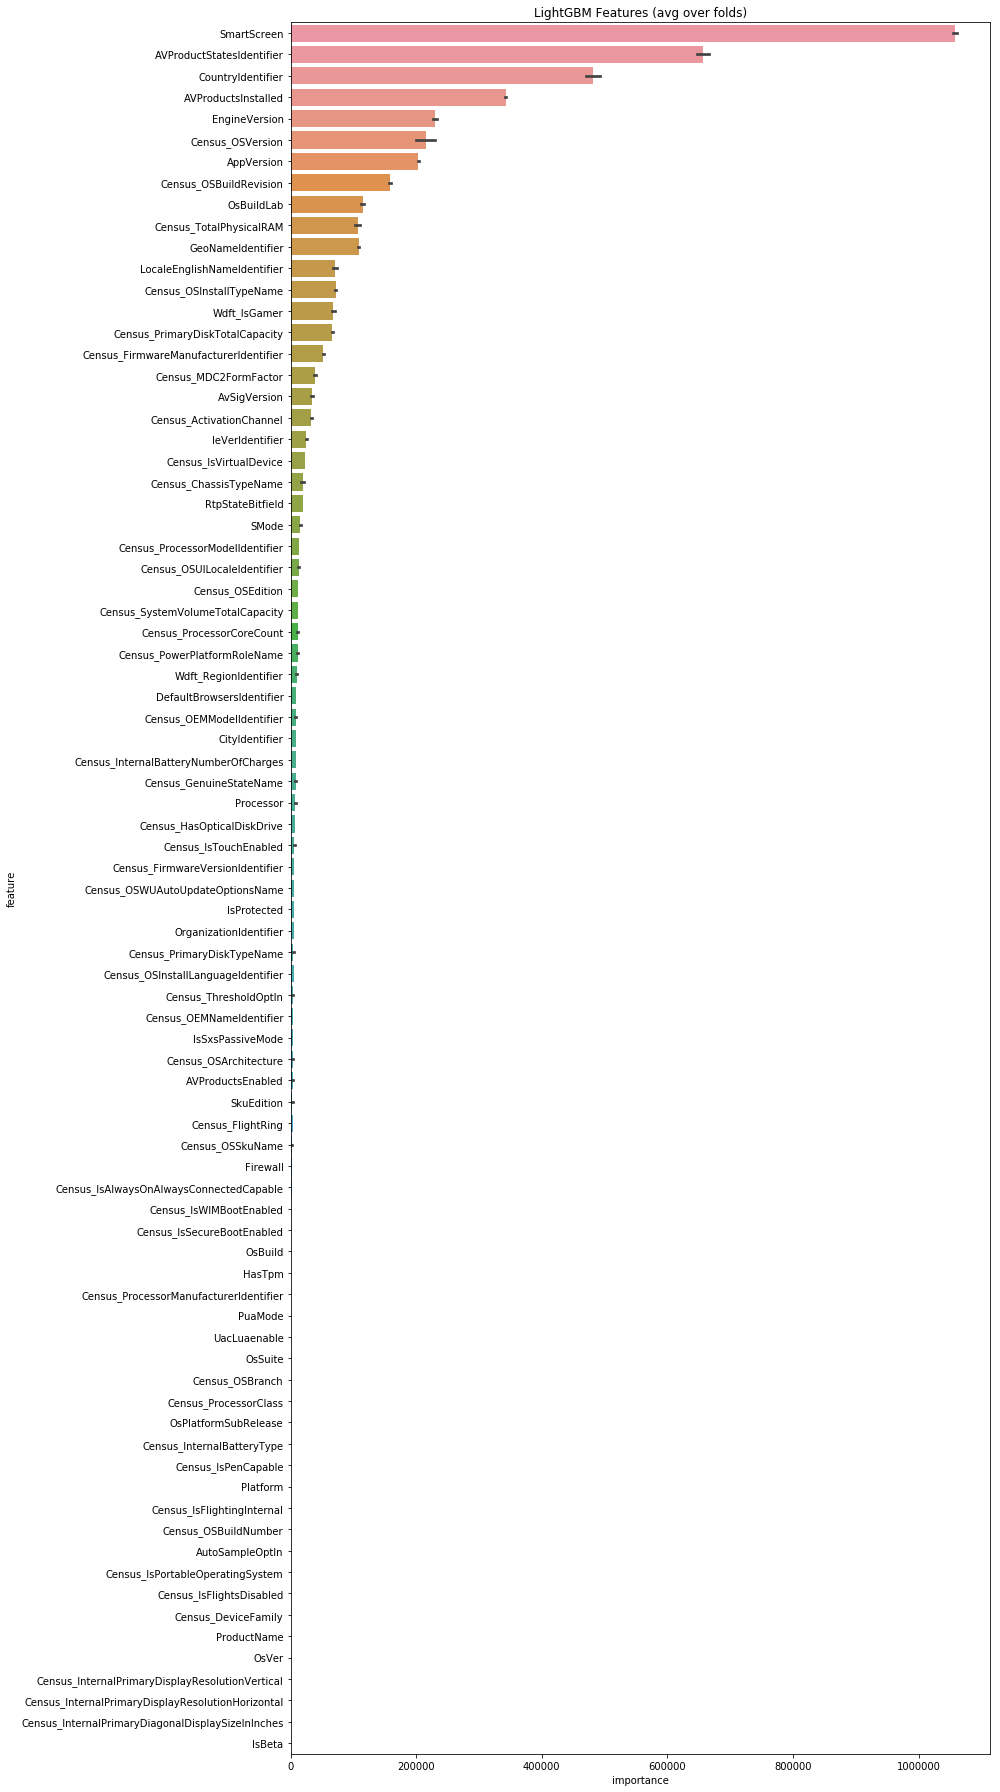

In [26]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission

In [ ]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions
sub_df[:10]

In [ ]:
sub_df.shape

In [ ]:
sub_df.to_csv("submit.csv", index=False)